# Assignment7-R-SVM
# 1 Assignment 7 - Support Vector Classifiers and Machines
# 1.1 Overview of the steps
1. Generate data and get an overview of the data
2. Learn and assess an support vector (soft margin) classifier
3. Learn and assess an SVM classifier
4. Learn and assess an SVM classifier for multiple classes
5. Apply SVM to Gene Expression Data
# 1.2 Steps in detail

In [1]:
%matplotlib notebook

import numpy.random
import pandas as pd
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import itertools

default_figsize = (8, 6)
default_alpha = .05
image_format = 'png'
default_colors = np.array(['red', 'blue', 'green'])

## 1.2.1 Generate data and get an overview of the data
### Generate the observations belonging to two classes.
Therefore, we use rnorm that generates a vector of n=20*2 normally distributed random numbers.
We split them into two columns in a predictor matrix x corresponding to two predictors and assign two classes in a response vector y: -1 to the first ten observations and 1 to the last ten observations.
Then we plot the data

In [2]:
random_state: np.random.RandomState = None


def reset_random(seed=1):
    global random_state
    random_state = np.random.RandomState(1)


def sample(df, n=None, replace=False):
    return df.sample(n if n is not None else len(df), replace=replace, random_state=random_state)


def normal_random(size):
    return random_state.normal(loc=0, scale=1, size=size)

In [3]:
def make_svm_x_y(size, y_split=.5):
    x = normal_random((size, 2))
    if y_split >= 0:
        minus_ones_count = int(y_split * size)
        y = np.concatenate((np.repeat(-1, minus_ones_count), np.repeat(1, size - minus_ones_count)))
    else:
        y = random_state.choice((1, -1), size, replace=True)
    x[y == 1] = x[y == 1] + 1
    return x, y

In [4]:
def plot_scatter(xy, z, colors=default_colors):
    fig, ax = plt.subplots(figsize=default_figsize)
    z_levels = np.unique(z)
    z_cmap, z_norm = from_levels_and_colors(np.append(z_levels, z_levels.max() + 1), colors[:len(z_levels)])
    ax.scatter(xy[:, 0], xy[:, 1], c=z, cmap=z_cmap, marker='o')
    fig.show()

<IPython.core.display.Javascript object>


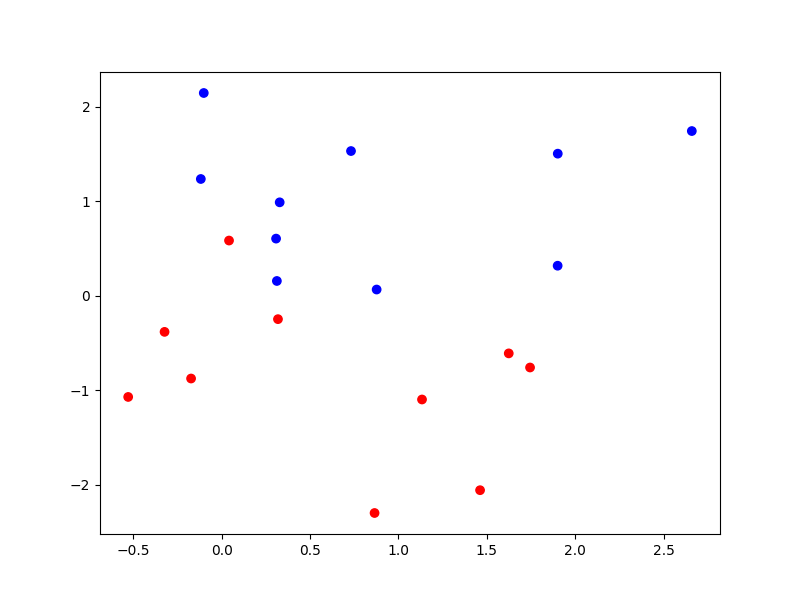

In [5]:
reset_random()
x, y = make_svm_x_y(20)
plot_scatter(x, y)

In [6]:
print('x =', x)
print('y =', y)

x = [[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071]
 [-0.3224172  -0.38405435]
 [ 1.13376944 -1.09989127]
 [-0.17242821 -0.87785842]
 [ 0.04221375  0.58281521]
 [-0.10061918  2.14472371]
 [ 1.90159072  1.50249434]
 [ 1.90085595  0.31627214]
 [ 0.87710977  0.06423057]
 [ 0.73211192  1.53035547]
 [ 0.30833925  0.60324647]
 [ 0.3128273   0.15479436]
 [ 0.32875387  0.9873354 ]
 [-0.11731035  1.2344157 ]
 [ 2.65980218  1.74204416]]
y = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1]


Check visually whether the classes are linearly separable. They are not.

## 1.2.2 Learn and assess a support vector (soft margine) classifier
### Fit the support vector classifier.

In [7]:
x_columns = ['x1', 'x2']
y_column = 'y'


def split_x_y(df):
    return df[x_columns], df[y_column]


def make_svm_df(x, y):
    return pd.DataFrame({
        x_columns[0]: pd.Series(x[:, 0], dtype=float),
        x_columns[1]: pd.Series(x[:, 1], dtype=float),
        y_column: pd.Series(y, dtype='category'),
    }, index=pd.Series(range(len(y)), dtype=int))

In [8]:
df = make_svm_df(x, y)
df

,x1,x2,y
0,1.624345,-0.611756,-1
1,-0.528172,-1.072969,-1
2,0.865408,-2.301539,-1
3,1.744812,-0.761207,-1
4,0.319039,-0.249370,-1
5,1.462108,-2.060141,-1
6,-0.322417,-0.384054,-1
7,1.133769,-1.099891,-1
8,-0.172428,-0.877858,-1
9,0.042214,0.582815,-1


> Ignoring Standard `scale` because it doesn't seem needed in this Notebook: all `y` are already scaled.

In [9]:
def fit_svc(x, y, kernel='linear', gamma='auto', C=1, cache_size=40, random_state=random_state, **kwargs):
    #  Ignored from R: `type` (not applicable: they are separate classes), `nu` (not used), `epsilon` (regression only), `cross` (cross-validation is a separate class), `fitted` (not sure; there is a separate method for fitting).
    return SVC(kernel=kernel, random_state=random_state, C=C, gamma=gamma, cache_size=cache_size, **kwargs).fit(x, y)

In [10]:
reset_random(1004)
svc_fit = fit_svc(*split_x_y(df), kernel='linear', C=10)

### Plot the support vector classifier obtained

In [11]:
svm_plot_mesh_size = .02


def plot_svm(svm, df, xy_columns, z_column, z_colors=default_colors, x_label=None, y_label=None):
    x, y, = df[xy_columns[0]], df[xy_columns[1]]
    z = df[z_column]
    z_levels = z.unique().to_numpy()
    z_cmap, z_norm = from_levels_and_colors(np.append(z_levels, z_levels.max() + 1), z_colors[:len(z_levels)])

    # create a mesh to plot in
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, svm_plot_mesh_size),
                         np.arange(y_min, y_max, svm_plot_mesh_size))

    fig, ax = plt.subplots()

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    zz = svm.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=xy_columns))

    # Put the result into a color plot
    zz = zz.reshape(xx.shape)
    ax.contourf(xx, yy, zz, cmap=z_cmap, alpha=0.4)

    # Plot also the training points
    scatter = ax.scatter(x, y, c=z, cmap=z_cmap)
    ax.legend(handles=scatter.legend_elements()[0], labels=list(z.unique()))
    ax.set_xlabel(x_label if x_label else xy_columns[0])
    ax.set_ylabel(y_label if y_label else xy_columns[1])
    ax.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], c='k', marker='x')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    fig.show()

<IPython.core.display.Javascript object>


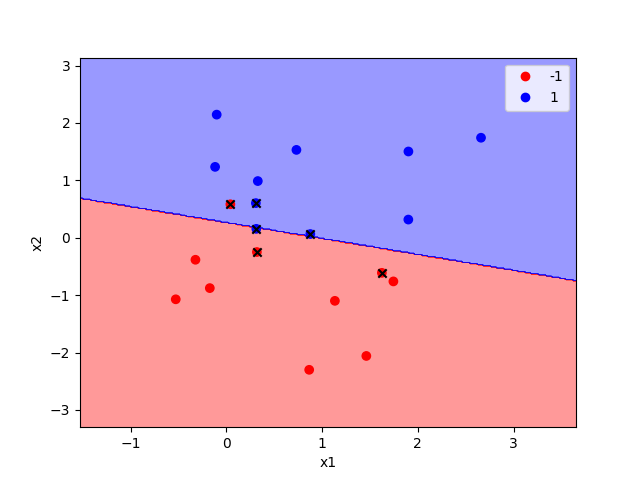

In [12]:
plot_svm(svc_fit, df, x_columns, y_column)

The support vectors are plotted as crosses and the remaining observations are plotted as circles; we see here that there are six support vectors.

### Determine support vectors' identities (row numbers in the data matrix).

In [13]:
svc_fit.support_

array([ 0,  4,  9, 13, 15, 16], dtype=int32)

### What if we instead used a smaller value of the C parameter?

<IPython.core.display.Javascript object>


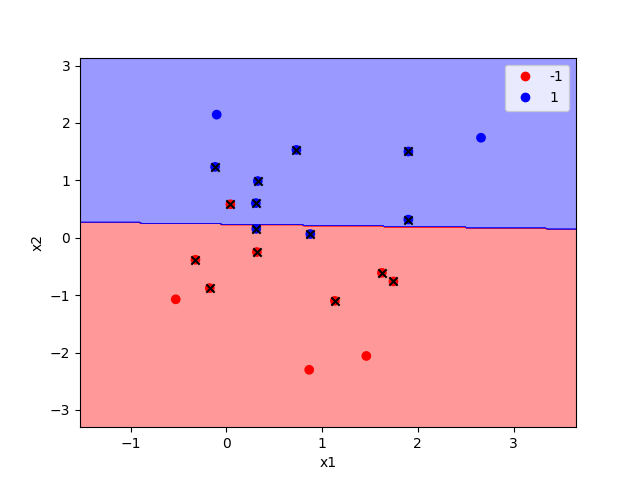

array([ 0,  3,  4,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18],
      dtype=int32)

In [14]:
reset_random(42)
svc_fit = fit_svc(*split_x_y(df), kernel='linear', C=.1)
plot_svm(svc_fit, df, x_columns, y_column)
svc_fit.support_

### Interpret the results and the variance-bias tradeoff.

SVM is a margin classifier: the hyperplane is defined by the vectors between upper and lower margins - support vectors (SVs). $C$ is a hyperparameter, which defines how much the margin violations are going to be punished.

The larger the $C$, the stronger the punishment, the smaller the margins, the fewer points lie between upper and lower margins, the smaller number of SVs. Basically, $C$ embodies the bias-variance trade-off: large values cause smaller margins, hence higher variance and possible overfitting; while smaller values cause larger margins, hence smaller variance, but higher bias and possible underfitting.

This can be confirmed by the 2 examples:
- for $C = 10$ there are 6 SVs and 2 misclassified point - better fitting, possible overfitting;
- for $C = 0.1$ there are 9 SVs and 3 misclassified point - worse fitting, likely, better performance on new samples.

### Perform cross-validation to determine the $C$ parameter

In [15]:
def cv_svm(sklearn_fit, param_dict, k, df, split_x_y, metric_name, calculate_metric, random_state=random_state):
    # Simple k-fold cross validation is used since no other requirements received.
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    results = pd.DataFrame({
        'K-Fold': pd.Series(dtype=int),
        'Params': pd.Series(dtype=object),
        'Model': pd.Series(dtype=object),
        metric_name: pd.Series(dtype=float),
    }, index=pd.Series(dtype=int))

    param_items = list(param_dict.items())
    param_names = [k for k, _ in param_items]
    params_product = list(itertools.product(*(v for _, v in param_items)))
    for i, (train_index, test_index) in enumerate(kf.split(df)):
        x_df, y_df = split_x_y(df.iloc[train_index])
        x_test_df, y_test_df = split_x_y(df.iloc[test_index])
        for params_values in params_product:
            params = dict(zip(param_names, params_values))
            clf = sklearn_fit(random_state=random_state, x=x_df, y=y_df, **params)
            results.loc[len(results.index)] = [i + 1, params, clf, calculate_metric(y_test_df, clf.predict(x_test_df))]
    return results

In [16]:
reset_random(105)
cv_results = cv_svm(fit_svc, {'C': (0.001, 0.01, 0.1, 1, 5, 10, 100)}, 10, df, split_x_y, 'Accuracy', accuracy_score)

In [17]:
def params_to_tuple(row, keys):
    params = row['Params']
    row['Params'] = tuple(params[k] for k in keys)
    return row


def cv_summary(cv_results, params_order, metric_name, calc_error=lambda metric: 1 - np.mean(metric),
               calc_dispersion=np.std):
    df = cv_results.apply(lambda row: params_to_tuple(row, params_order), axis=1)

    aggregated = df.groupby('Params').apply(
        lambda df: pd.Series([calc_error(df[metric_name]), calc_dispersion(df[metric_name])],
                             index=['Error', 'Dispersion']))
    aggregated.sort_index(inplace=True)
    params_column = f'Params: {params_order}'
    aggregated.insert(0, params_column, aggregated.index)
    aggregated.index = pd.Series(range(aggregated.shape[0]), dtype=int)

    model_name = ', '.join(df['Model'].apply(lambda model: type(model).__name__).drop_duplicates())
    display(Markdown(f'#### Parameter tuning of "{model_name}":'))
    display(Markdown(f'##### - sampling method: {df["K-Fold"].max()}-fold cross validation'))
    display(Markdown(f'##### - best parameters:'))
    best_rows = aggregated[aggregated['Error'] == aggregated['Error'].min()]
    best_params = {}
    for i, k in enumerate(params_order):
        best_params[k] = column = []
        for params in best_rows[params_column]:
            column.append(params[i])

    display(pd.DataFrame(best_params, index=pd.Series(range(best_rows.shape[0]), dtype=int)))
    display(Markdown(f'##### - best performance: {best_rows.iloc[0]["Error"]}'))
    display(Markdown(f'##### - Detailed performance results:'))
    display(aggregated)

In [18]:
param_names = ('C',)
cv_summary(cv_results, param_names, 'Accuracy')

#### Parameter tuning of "SVC":

##### - sampling method: 10-fold cross validation

##### - best parameters:

,C
0,1
1,5
2,10
3,100


##### - best performance: 0.09999999999999998

##### - Detailed performance results:

,"Params: ('C',)",Error,Dispersion
0,"(0.001,)",0.25,0.403113
1,"(0.01,)",0.25,0.403113
2,"(0.1,)",0.15,0.229129
3,"(1,)",0.10,0.200000
4,"(5,)",0.10,0.200000
5,"(10,)",0.10,0.200000
6,"(100,)",0.10,0.200000


### Interpret the results.

After performing cross-validation, it's possible to see that there are multiple values of $C$, which produced the smallest error.

$C = 1$ is the smallest. Since large values could produce overfitting, $C = 1$ will be considered the best.

### Capture the best model.

> Since there is a different API in Python, getting the best model requires slightly more work, compared to R.

In [19]:
def cv_best_svm(cv_results, params):
    best_models = cv_results[
        (cv_results['Params'] == params) & (cv_results['Accuracy'] == cv_results['Accuracy'].max())]
    best_models.insert(best_models.columns.shape[0], '_n_vectors',
                       best_models['Model'].apply(lambda model: model.support_vectors_.shape[0]))
    return best_models.nlargest(1, '_n_vectors').iloc[0]

In [20]:
best_model = cv_best_svm(cv_results, {'C': 1})['Model']

In [21]:
def print_svm(model, param_names):
    params = model.get_params()
    input_params = [(n, params[n]) for n in param_names]
    df = pd.DataFrame({'': [type(model).__name__, params['kernel'], *(v for _, v in input_params)]},
                      index=pd.Series(['SVM-Type', 'SVM-Kernel', *(n for n, _ in input_params)], name='Parameters:'))
    display(df)
    display(Markdown(f'#### Number of Support Vectors: {model.support_vectors_.shape[0]}\n{model.n_support_}'))
    display(Markdown(f'#### Number of Classes: {model.classes_.shape[0]}'))
    display(Markdown(f'#### Levels:\n{model.classes_}'))

In [22]:
print_svm(best_model, param_names)

,
Parameters:,
SVM-Type,SVC
SVM-Kernel,linear
C,1


#### Number of Support Vectors: 9
[5 4]

#### Number of Classes: 2

#### Levels:
[-1  1]

### Generate test data (a sample of the same distribution) as before.

In [23]:
reset_random()
x_test, y_test = make_svm_x_y(20, -1)
test_df = make_svm_df(x_test, y_test)

### Predict the class labels of these test observations.

Use the best model obtained through cross-validation in order to make predictions.

In [24]:
def crosstable(levels, actual, predicted):
    d = {}
    for level in levels:
        d[level] = {}
    for row in d.values():
        for level in d.keys():
            row[level] = 0
    for i in range(0, len(actual)):
        d[actual[i]][predicted[i]] += 1
    return d


def crosstable_df(levels, actual, predicted):
    d = crosstable(levels, actual, predicted)
    df = pd.DataFrame(d)
    df.index.set_names('Actual', inplace=True)
    df.columns.set_names('Predicted', inplace=True)
    return df


def accuracy(ct_df):
    return np.trace(ct_df) / ct_df.to_numpy().sum()

In [25]:
y_pred = best_model.predict(test_df[x_columns])
ct_df = crosstable_df(best_model.classes_, y_test, y_pred)
display(ct_df)
display(Markdown(f'##### Accuracy: {accuracy(ct_df)}'))

Predicted,-1,1
Actual,,
-1,9,0
1,3,8


##### Accuracy: 0.85

### Interpret the results.

The accuracy of the model is $0.85$. It is a good result, the accuracy is identical to the task R assignment. But my SVM classifier uses only $8$ support vectors as compared to R's $16$ vectors. Based on this, I am afraid of possible overfitting of my model.

## 1.2.3 Learn and assess an SVM classifier

### First, generate some data with a non-linear class boundary, as before. Generate $200$ instead of $20$ observations.

<IPython.core.display.Javascript object>


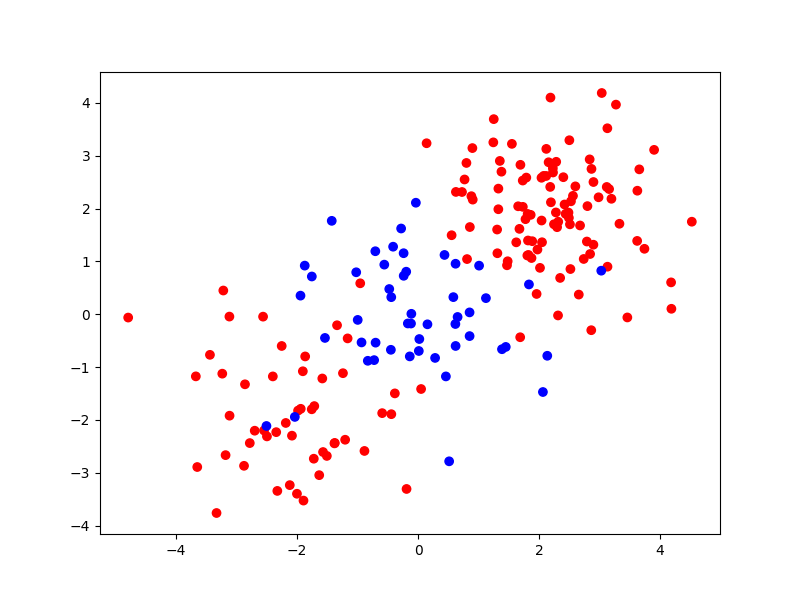

In [26]:
reset_random()
x = normal_random((200, 2))
x[0:99] = x[0:99] + 2
x[100:149] = x[100:149] - 2
y = np.concatenate((np.repeat(-1, 150), np.repeat(1, 50)))
df = make_svm_df(x, y)
plot_scatter(x, y)

In [27]:
display(df)

,x1,x2,y
0,3.624345,1.388244,-1
1,1.471828,0.927031,-1
2,2.865408,-0.301539,-1
3,3.744812,1.238793,-1
4,2.319039,1.750630,-1
...,...,...,...
195,-1.426555,1.767960,1
196,-0.475373,0.477610,1
197,-1.021886,0.794528,1
198,-1.873161,0.920615,1


### Split the data randomly into training and testing groups. Then fit the training data using an SVM model with a radial kernel and $γ = 1$.

<IPython.core.display.Javascript object>


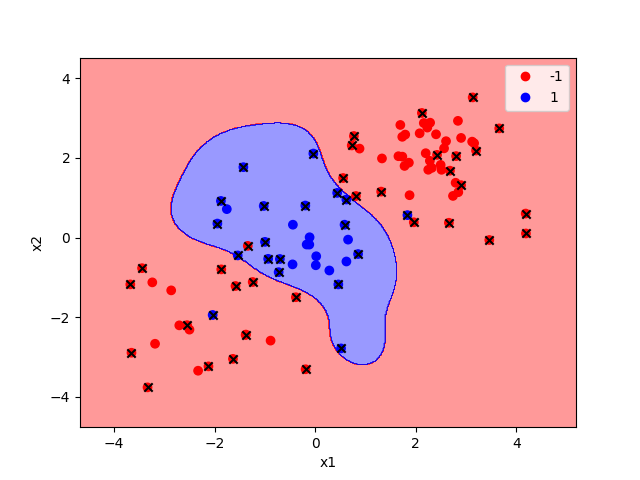

In [28]:
reset_random(54)
train_df = sample(df, 100)
test_df = df.loc[df.index.difference(train_df.index)]
svc_fit = fit_svc(*split_x_y(train_df), kernel='rbf', gamma=1, C=1)
plot_svm(svc_fit, train_df, x_columns, y_column)

### Use cross-validation to select the best choice of $C$ and $γ$.

In [29]:
param_dict = {'C': (0.1, 1, 10, 100, 1000), 'gamma': (0.5, 1, 2, 3, 4)}
param_names = tuple(param_dict.keys())

reset_random(100)
cv_results = cv_svm(lambda **kwargs: fit_svc(kernel='rbf', **kwargs),
                    param_dict, 10, train_df, split_x_y, 'Accuracy',
                    accuracy_score)

In [30]:
cv_summary(cv_results, param_names, 'Accuracy')

#### Parameter tuning of "SVC":

##### - sampling method: 10-fold cross validation

##### - best parameters:

,C,gamma
0,1,0.5


##### - best performance: 0.07999999999999985

##### - Detailed performance results:

,"Params: ('C', 'gamma')",Error,Dispersion
0,"(0.1, 0.5)",0.18,0.116619
1,"(0.1, 1)",0.26,0.156205
2,"(0.1, 2)",0.30,0.134164
3,"(0.1, 3)",0.30,0.134164
4,"(0.1, 4)",0.30,0.134164
5,"(1, 0.5)",0.08,0.087178
6,"(1, 1)",0.09,0.094340
7,"(1, 2)",0.11,0.104403
8,"(1, 3)",0.13,0.100499
9,"(1, 4)",0.13,0.100499


### Interpret the results.

During cross-validation with $C$ and $\gamma$ parameters tuning, the best result was found: it is $C = 1$ and $\gamma = 1$, which is only slightly different from the R assignment. The mean error (1 - accuracy) is only 12%, which is a good result.

Moreover, I feel more satisfied with this round parameter tuning, because, unlike in linear-kerneled SVM, there is only one model, which has the best parameters. Also, dispersion (standard deviance of the accuracy) is less that 10%, which is even better than parameter tuning with cross-validation for the linear SVM and it additionally enforces the certainty in the results of this parameters tuning round.

### Assess the test set predictions for the best model.

In [31]:
best_model = cv_best_svm(cv_results, {'C': 1, 'gamma': 1})['Model']
y_pred = best_model.predict(test_df[x_columns])
ct_df = crosstable_df(best_model.classes_, test_df[y_column].to_numpy(), y_pred)
print_svm(best_model, param_names)
display(ct_df)
display(Markdown(f'##### Accuracy: {accuracy(ct_df)}'))

,
Parameters:,
SVM-Type,SVC
SVM-Kernel,rbf
C,1
gamma,1


#### Number of Support Vectors: 51
[32 19]

#### Number of Classes: 2

#### Levels:
[-1  1]

Predicted,-1,1
Actual,,
-1,77,5
1,3,15


##### Accuracy: 0.92

### Interpret the results.

The best model shows excellent accuracy of 92%. There are 55 support vectors in this model, so I don't think that overfitting is likely.

## 1.2.4 Learn and assess an SVM classifier for multiple classes

### Generate data as before. We simply extend the matrix $x$ with $50$ new rows and assign these rows a new class.

<IPython.core.display.Javascript object>


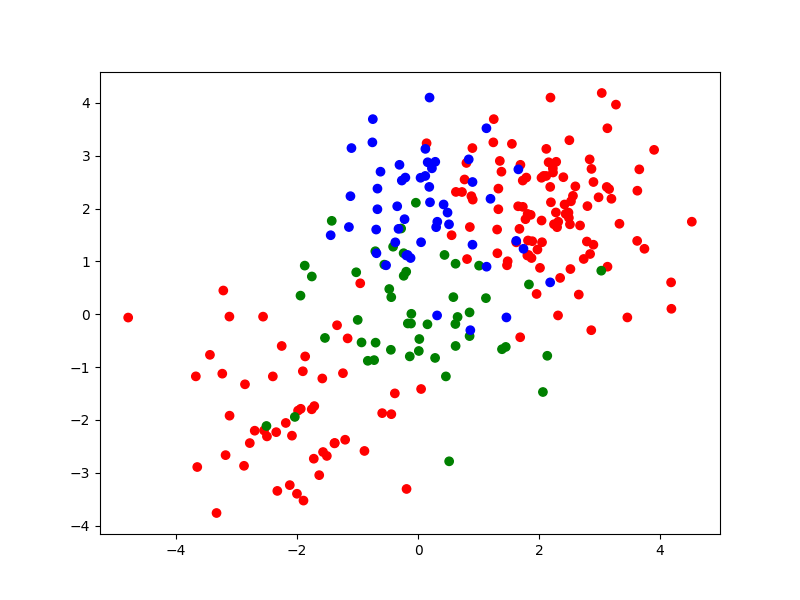

In [32]:
reset_random()
x = np.concatenate((x, normal_random((50, 2))))
y = np.concatenate((y, np.repeat(0, 50)))
x[y==0, 1]=x[y==0, 1] + 2
df = make_svm_df(x, y)
plot_scatter(x, y)

In [33]:
display(df)

,x1,x2,y
0,3.624345,1.388244,-1
1,1.471828,0.927031,-1
2,2.865408,-0.301539,-1
3,3.744812,1.238793,-1
4,2.319039,1.750630,-1
...,...,...,...
245,1.198918,2.185156,0
246,-0.375285,1.361270,0
247,0.423494,2.077340,0
248,-0.343854,2.043597,0


### Fit an SVM to the training data.

<IPython.core.display.Javascript object>


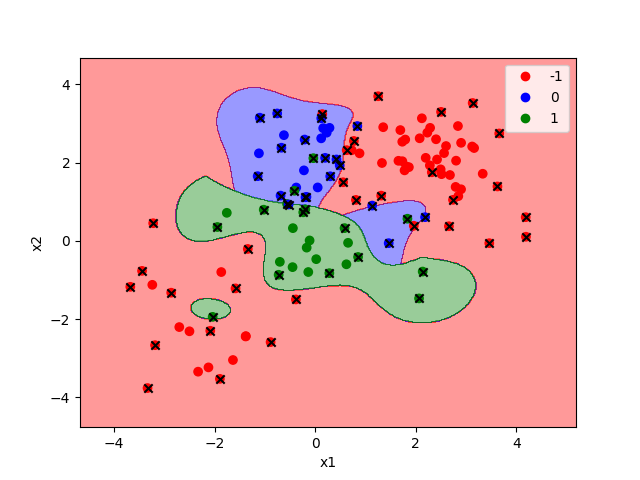

In [34]:
reset_random(23)
train_df = sample(df, 125)
test_df = sample(df, 125)
svc_fit = fit_svc(*split_x_y(train_df), kernel='rbf', C=10, gamma=1)
plot_svm(svc_fit, train_df, x_columns, y_column)

### Find the right parameters using cross validation.

In [35]:
param_dict = {'C': (0.1, 1, 10, 100, 1000), 'gamma': (0.5, 1, 2, 3, 4)}
param_names = tuple(param_dict.keys())

reset_random(22)
cv_results = cv_svm(lambda **kwargs: fit_svc(kernel='rbf', **kwargs),
                    param_dict, 10, train_df, split_x_y, 'Accuracy',
                    accuracy_score)

In [36]:
cv_summary(cv_results, param_names, 'Accuracy')

#### Parameter tuning of "SVC":

##### - sampling method: 10-fold cross validation

##### - best parameters:

,C,gamma
0,1,2


##### - best performance: 0.15256410256410258

##### - Detailed performance results:

,"Params: ('C', 'gamma')",Error,Dispersion
0,"(0.1, 0.5)",0.304487,0.172131
1,"(0.1, 1)",0.416026,0.153805
2,"(0.1, 2)",0.416026,0.153805
3,"(0.1, 3)",0.416026,0.153805
4,"(0.1, 4)",0.416026,0.153805
5,"(1, 0.5)",0.167308,0.102301
6,"(1, 1)",0.159615,0.087492
7,"(1, 2)",0.152564,0.096784
8,"(1, 3)",0.176282,0.119590
9,"(1, 4)",0.184615,0.121518


### Assess the test set predictions for the best model.

In [37]:
best_model = cv_best_svm(cv_results, {'C': 1, 'gamma': 2})['Model']
y_pred = best_model.predict(test_df[x_columns])
ct_df = crosstable_df(best_model.classes_, test_df[y_column].to_numpy(), y_pred)
print_svm(best_model, param_names)
display(ct_df)
display(Markdown(f'##### Accuracy: {accuracy(ct_df)}'))

,
Parameters:,
SVM-Type,SVC
SVM-Kernel,rbf
C,1
gamma,2


#### Number of Support Vectors: 83
[42 21 20]

#### Number of Classes: 3

#### Levels:
[-1  0  1]

Predicted,-1,0,1
Actual,,,
-1,78,6,3
0,1,18,4
1,2,2,11


##### Accuracy: 0.856

### Interpret the results.

The behaviour of radial SVM for 3 classes is very similar to the radial SVM for 2 classes:
- there exist only 1 set of the best parameters - $C = 1$ and $\gamma = 2$);
- the model accuracy is high - 85% for 3 categories, while 92% for 2 categories.

Another change is that since now there are 3 classes, there are 3 separate subsets of support vectors each supporting the corresponding class. The `-1` class, which has the most datapoints in the dataset, has the most support vectors.

In general, SVM with radial kernel seem quite powerful in separating even seemingly intricate data.

## 1.2.5 Apply SVM to Gene Expression Data

The `Khan` data set consists of gene expression measurements for 2, 308 genes and the corresponding 4 cancer subtypes. The training and test sets consist of 63 and 20 data points, respectively.

### Load the data and get yourself an overview.

> I used the files, downloaded from the [MyMoodle question](https://mymoodle.lnu.se/mod/forum/discuss.php?d=2160521#p5237284).

In [38]:
khan_train_x_df = pd.read_csv('./Khan_xtrain.csv', index_col=[0])
khan_train_y_df = pd.read_csv('./Khan_ytrain.csv', index_col=[0])
khan_test_x_df = pd.read_csv('./Khan_xtest.csv', index_col=[0])
khan_test_y_df = pd.read_csv('./Khan_ytest.csv', index_col=[0])
print(f'Khan_xtrain shape: {khan_train_x_df.shape}')
print(f'Khan_xtest shape: {khan_test_x_df.shape}')
display(Markdown('##### Khan_xtrain preview:'), khan_train_x_df)
display(Markdown('##### Khan_ytrain preview:'), khan_train_y_df)
display(Markdown('##### Khan_xtest preview:'), khan_test_x_df)
display(Markdown('##### Khan_ytest preview:'), khan_test_y_df)

khan_train_y_df['x'] = khan_train_y_df['x'].astype('category')
khan_train_y_df.rename(columns={'x': 'y'}, inplace=True)
khan_test_y_df['x'] = khan_test_y_df['x'].astype('category')
khan_test_y_df.rename(columns={'x': 'y'}, inplace=True)

Khan_xtrain shape: (63, 2308)
Khan_xtest shape: (20, 2308)


##### Khan_xtrain preview:

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V2299,V2300,V2301,V2302,V2303,V2304,V2305,V2306,V2307,V2308
V1,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,0.565427,...,-0.238511,-0.027474,-1.660205,0.588231,-0.463624,-3.952845,-5.496768,-1.414282,-0.647600,-1.763172
V2,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,0.159053,...,-0.657394,-0.246284,-0.836325,-0.571284,0.034788,-2.478130,-3.661264,-1.093923,-1.209320,-0.824395
V3,-0.084469,-1.649739,-0.241308,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,0.496585,...,-0.696352,0.024985,-1.059872,-0.403767,-0.678653,-2.939352,-2.736450,-1.965399,-0.805868,-1.139434
V4,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,0.994732,...,0.259746,0.357115,-1.893128,0.255107,0.163309,-1.021929,-2.077843,-1.127629,0.331531,-2.179483
V5,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,0.278313,...,-0.200404,0.061753,-2.273998,-0.039365,0.368801,-2.566551,-1.675044,-1.082050,-0.965218,-1.836966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V59,-2.683846,-2.117767,-0.523236,-2.174192,-0.448947,0.543022,1.338731,0.194250,0.599276,0.637370,...,-1.681471,-1.036765,-0.422204,-1.400799,-2.831914,-4.667046,-2.354932,-1.220102,-0.435100,-1.444771
V60,-1.207646,-2.478130,0.094310,0.273456,-1.113218,-0.283690,1.105985,0.801284,0.381582,0.714811,...,-0.929629,-0.258512,-1.482365,-0.827136,-1.543182,-1.549755,-0.532730,-1.759099,0.570471,-2.232127
V61,-1.684161,-2.053384,0.563835,0.314446,-2.052605,-0.630172,1.570967,0.137324,1.036985,0.973654,...,-0.537683,-0.497909,-0.477552,-1.427950,-1.928955,-2.544657,-1.080576,-1.382302,-0.804973,-1.318262
V62,-2.258568,-2.308603,-1.443076,0.233094,-1.779633,-0.030665,1.532665,-0.408419,0.795162,0.376242,...,-2.276917,-0.245517,-0.815315,-1.288079,-2.835316,-2.169804,-0.630172,-0.870839,-0.315533,-1.326140


##### Khan_ytrain preview:

,x
1,2
2,2
3,2
4,2
5,2
...,...
59,1
60,1
61,1
62,1


##### Khan_xtest preview:

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V2299,V2300,V2301,V2302,V2303,V2304,V2305,V2306,V2307,V2308
V1,0.139501,-1.168927,0.564973,-3.366796,-1.323132,-0.692547,2.327395,0.923703,0.112167,0.509765,...,-0.180803,-0.942635,-1.210662,-0.588787,-0.070422,-2.783852,-2.840439,-1.160913,-0.343054,-0.055513
V2,1.164275,-2.018158,1.103533,-2.165435,-1.440117,-0.437420,2.661587,1.224011,0.210504,1.045563,...,-0.709480,-1.532940,-2.385967,-0.389641,0.422781,-2.816750,-2.422495,-1.722607,-1.703749,-1.699910
V4,0.841093,0.254720,-0.208748,-2.148149,-1.512765,-1.263723,2.946642,0.087828,0.482920,1.063020,...,-0.067958,-1.854060,-1.541312,-1.773723,-1.879935,-2.265289,-2.405726,-0.176379,-0.128743,-0.996417
V6,0.685065,-1.927579,-0.233068,-1.640413,-1.008954,0.774451,1.617168,-0.567925,0.036621,-0.101701,...,1.077559,-0.263966,-1.966113,-1.086190,0.885914,-0.248590,0.385874,-0.508163,-0.626985,-0.699366
V7,-1.956163,-2.234926,0.281563,-2.695628,-1.214697,-1.059872,2.498070,0.780196,1.041583,0.727500,...,-1.209320,-0.693147,-1.846427,-0.993442,-3.294138,-3.332605,-2.282782,-0.656622,-2.012157,-1.668657
V8,-0.258641,-1.684700,0.175800,-2.323809,-1.692276,-0.008637,2.302135,0.455778,-0.342490,0.716522,...,-2.049494,-1.223835,-1.140372,-0.952436,0.294012,-1.205307,-1.457576,-0.655081,-0.060493,-0.980563
V10,-1.109875,-1.046969,-0.853786,-2.607752,-1.770781,-1.259133,1.426380,-0.743599,0.613129,-0.533071,...,-0.963120,-1.016940,-0.991553,-0.643405,-2.323809,-1.435485,-0.484995,0.479335,-1.006489,-0.778487
V12,1.471485,-1.751578,-0.256700,-1.899122,-1.364924,-1.198654,2.489878,-0.035006,0.833474,0.779279,...,-0.000900,-1.020263,-1.599488,-2.273998,-0.559141,-1.985587,-1.044124,-1.064211,-1.179605,-0.499556
V14,-0.396159,-1.191386,0.696691,-1.862397,-1.312672,0.744980,1.762708,1.034038,0.802943,0.953471,...,-1.104429,-0.955811,-0.438505,-0.845366,-0.372659,0.059118,-1.209320,-0.220148,0.452031,-1.119325
V15,-2.136224,-2.236797,-0.946492,-2.777400,-1.822631,-0.455233,2.547514,-0.270366,1.437866,0.543777,...,-1.552585,-0.649513,-1.159318,-0.809456,-2.993734,-2.431555,-0.589148,-0.790319,-0.536485,-1.935168


##### Khan_ytest preview:

,x
1,3
2,2
3,4
4,2
5,1
6,3
7,4
8,2
9,3
10,1


### Use a support vector approach to predict the cancer subtypes using gene expression measurements.

In this data set, there are a very large number of features relative to the number of observations.
This suggests that we should use a linear kernel, because the additional flexibility that will result
from using a polynomial or radial kernel is unnecessary.

In [39]:
reset_random(42)
params = {'C': 10}
svc_fit = fit_svc(khan_train_x_df, khan_train_y_df.squeeze(), kernel='linear', **params)
print_svm(svc_fit, params.keys())

,
Parameters:,
SVM-Type,SVC
SVM-Kernel,linear
C,10


#### Number of Support Vectors: 54
[ 7 18  9 20]

#### Number of Classes: 4

#### Levels:
[1 2 3 4]

### Assess the training error.

In [40]:
ct_df = crosstable_df(svc_fit.classes_, khan_train_y_df.squeeze().to_numpy(), svc_fit.predict(khan_train_x_df))
display(ct_df)
display(Markdown(f'##### Accuracy: {accuracy(ct_df)}'))

Predicted,1,2,3,4
Actual,,,,
1,8,0,0,0
2,0,23,0,0
3,0,0,12,0
4,0,0,0,20


##### Accuracy: 1.0

We see that there are no training errors. In fact, this is not surprising, because the large number of variables relative to the number of observations implies that it is easy to find hyperplanes that fully separate the classes. We are most interested not in the support vector classifier’s performance on the training observations, but rather its performance on the test observations.

### Assess the test error.

In [41]:
y_pred = svc_fit.predict(khan_test_x_df)
ct_df = crosstable_df(svc_fit.classes_, khan_test_y_df.squeeze().to_numpy(), y_pred)
display(ct_df)
display(Markdown(f'##### Accuracy: {accuracy(ct_df)}'))

Predicted,1,2,3,4
Actual,,,,
1,3,0,0,0
2,0,6,2,0
3,0,0,4,0
4,0,0,0,5


##### Accuracy: 0.9

### Interpret the results.

I am genuinely amazed by SVM performance on so many features: the accuracy on the test data is 90%. This asserts the idea of high horizontal scalability of SVM classifiers.

What is even more interesting for me is that the model is "overfit" on the training data - the accuracy is 100%.

# TODO:
- next time use color dict, so that each class has consistent colors. Now switching from 2 to 3 classes swaps blue and green color, because new class - `0` is between `-1` and `1`;